# Exercise: beam bending with the least squares method

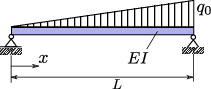

The differential equation for beam bending
$$
(EI w'')'' - q = 0
$$
can be integrated analytically by specifying the linear loading as $q = q_0\frac{x}{L}$ and the boundary conditions
$$
w(0) = 0\\
w(L) = 0\\
w''(0)=0\\
w''(L) = 0
$$
to yield the deflection solution ("Biegelinie"):
$$
w(x) = \frac{q_0 L^4}{360 EI} \left[ 3\left(\frac{x}{L}\right)^5 - 10 \left(\frac{x}{L}\right)^3 + 7 \left(\frac{x}{L}\right)\right]
$$
We now seek to approximate this solution numerically using the least squares method.

In [19]:
import numpy as np #numerical methods
import sympy as sp #symbolic operations
import matplotlib.pyplot as plt #plotting
sp.init_printing(use_latex='mathjax') #makes sympy output look nice

#Some plot settings
plt.style.use('seaborn-deep')
plt.rcParams['lines.linewidth']= 2.0
plt.rcParams['lines.color']= 'black'
plt.rcParams['legend.frameon']=True
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['legend.fontsize']=14
plt.rcParams['font.size'] = 14
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.axisbelow'] = True

In [20]:
#Defining the geometric an material characteristics as symbolic quantities
L,q,EI,x = sp.symbols('L q_0 EI x')

In [21]:
#Analytical solution to deflection
def deflection_analytical():
    a = x/L
    f = q*L**4/(360 * EI)
    return f*(3*a**5 - 10*a**3 + 7*a)

In [22]:
deflection_analytical() #check definition

      ⎛          3      5⎞
 4    ⎜7⋅x   10⋅x    3⋅x ⎟
L ⋅q₀⋅⎜─── - ───── + ────⎟
      ⎜ L       3      5 ⎟
      ⎝        L      L  ⎠
──────────────────────────
          360⋅EI          

Now, let's plot the analytical solution. For that purpose, we use some Python magic ("lambdify"). We sample the analytical solution for $x \in [0,L]$ at 100 points and plot the dimensionless deflection over the dimensionless length.

Text(0,0.5,'$w / L^4 q_0  EI^{-1}$')

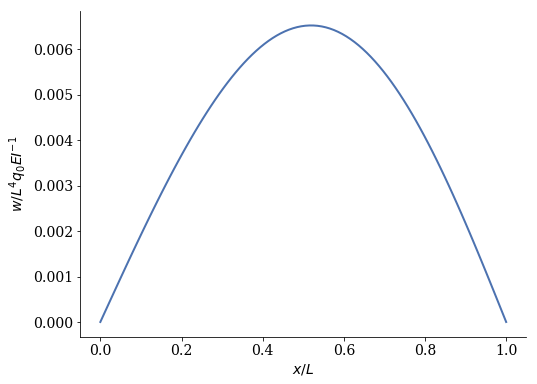

In [23]:
lam_x = sp.lambdify(x, deflection_analytical(), modules=['numpy'])
#For the variable x the function deflection_analytical() will obtain something

x_vals = np.linspace(0, 1, 100)*L #This something is x from 0 to L
analytical = lam_x(x_vals) #We calculate the solution by passing x = [0,...,L] to deflection_analytical

plt.plot(x_vals/L, analytical/(L**4*q)*EI)
plt.xlabel('$x / L$')
plt.ylabel('$w / L^4 q_0  EI^{-1}$')

## Trigonometric Ansatz

Let's try the approximation
$$
    \tilde{w} = a_1 \sin \left(\pi \frac{x}{L}\right) + a_2 \sin \left(2\pi\frac{x}{L}\right)
$$

In [24]:
a1, a2 = sp.symbols('a_1 a_2')#Defining the free values as new symbols

In [25]:
def deflection_ansatz():
    return a1*sp.sin(sp.pi/L*x) + a2*sp.sin(2*sp.pi/L*x) #defining the approximate solution with the unknown coefficients

Now we substitute this solution into the fourth-order ODE for beam bending by differentiating it twice and adding the distributed loading:
$$
EI w^\text{IV} - q_0 \frac{x}{L} = 0 \text{ with } EI = \text{const.}
$$

In [26]:
r = EI * deflection_ansatz().diff(x,4) - q * (x/L) #residual
r

 4    ⎛      ⎛π⋅x⎞            ⎛2⋅π⋅x⎞⎞       
π ⋅EI⋅⎜a₁⋅sin⎜───⎟ + 16⋅a₂⋅sin⎜─────⎟⎟       
      ⎝      ⎝ L ⎠            ⎝  L  ⎠⎠   q₀⋅x
────────────────────────────────────── - ────
                   4                      L  
                  L                          

Now we perform the derivatives with respect to the Ansatz free values for obtaining the stationarity of $\int 1/2 r^2 \text{d} x$:

In [27]:
dr_da1 = r.diff(a1)
dr_da2 = r.diff(a2)
dr_da1, dr_da2

⎛ 4       ⎛π⋅x⎞      4       ⎛2⋅π⋅x⎞⎞
⎜π ⋅EI⋅sin⎜───⎟  16⋅π ⋅EI⋅sin⎜─────⎟⎟
⎜         ⎝ L ⎠              ⎝  L  ⎠⎟
⎜──────────────, ───────────────────⎟
⎜       4                  4        ⎟
⎝      L                  L         ⎠

This yields the two equations to be solved:

In [28]:
stationarity_conditions = (sp.integrate(dr_da1*r,(x,0,L)),sp.integrate(dr_da2*r,(x,0,L)))

In [29]:
coefficients = sp.solve(stationarity_conditions,a1,a2)

In [30]:
coefficients

⎧       4           4     ⎫
⎪    2⋅L ⋅q₀      -L ⋅q₀  ⎪
⎨a₁: ───────, a₂: ────────⎬
⎪      5              5   ⎪
⎩     π ⋅EI       16⋅π ⋅EI⎭

In [31]:
deflection_ansatz().subs([(a1,coefficients[a1]),(a2,coefficients[a2])]).simplify()

 4    ⎛      ⎛π⋅x⎞      ⎛2⋅π⋅x⎞⎞
L ⋅q₀⋅⎜32⋅sin⎜───⎟ - sin⎜─────⎟⎟
      ⎝      ⎝ L ⎠      ⎝  L  ⎠⎠
────────────────────────────────
                5               
            16⋅π ⋅EI            

Now we're ready to plot the result and compare it to the analytical solution. 

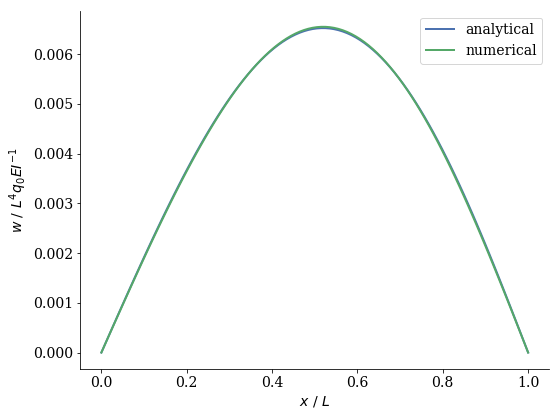

In [32]:
#We first substite the now known Ansatz free values into our Ansatz
z = sp.symbols('z')
w_numerical = deflection_ansatz().subs([(a1,coefficients[a1]),(a2,coefficients[a2]),(x,z*L)])
#We also made the coordinate dimensionless (x/L --> z) because of sympy problems

lam_x_num = sp.lambdify(z, w_numerical, modules=['numpy'])
#For the variable x the expression w_numerical will be given something
z_vals = np.linspace(0, 1,100) #This something is z from 0 to 1
numerical = lam_x_num(z_vals) #We calculate the solution by passing x = [0,...,L] to deflection_analytical
plt.plot(x_vals/L, analytical/(L**4*q)*EI,label='analytical')
plt.plot(z_vals, numerical/(L**4*q)*EI,label='numerical')
plt.legend()
plt.xlabel('$x\ /\ L$')
plt.ylabel('$w\ /\ L^4 q_0  EI^{-1}$')
plt.tight_layout()
plt.savefig('beam_least_squares.pdf')

In [33]:
print("Maximum absolute error: ", np.max(np.abs(analytical/(L**4*q)*EI - numerical/(L**4*q)*EI)))

Maximum absolute error:  3.41648400857485e-5


We can also plot and compare the bending moment. Let's first find the analytical expression by symbolically differentiating the deflection expression twice to obtain $M(x) = -EI w''(x)$:

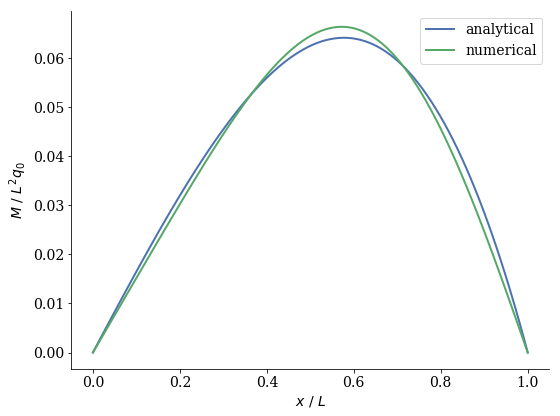

In [34]:
#analytical bending moment
moment_analytical = -deflection_analytical().diff(x,2)*EI
#numerical bending moment
moment_numerical = -deflection_ansatz().subs([(a1,coefficients[a1]),(a2,coefficients[a2])]).diff(x,2)*EI

#create lambdas for plotting along dimensionless length z
lam_x_analyt = sp.lambdify(z, moment_analytical.subs(x,z*L), modules=['numpy'])
lam_x_num = sp.lambdify(z, moment_numerical.subs(x,z*L), modules=['numpy'])
z_vals = np.linspace(0, 1,100)
analytical = lam_x_analyt(z_vals)
numerical = lam_x_num(z_vals)

#plot
plt.plot(x_vals/L, analytical/(L**2*q),label='analytical')
plt.plot(z_vals, numerical/(L**2*q),label='numerical')
plt.xlabel('$x\ /\ L$')
plt.ylabel('$M\ /\ L^2 q_0$')
plt.legend()
plt.tight_layout()
plt.savefig('beam_least_squares_moment.pdf')

In [35]:
print("Maximum absolute error in bending moment: ", np.max(np.abs(analytical/(L**2*q) - numerical/(L**2*q))))

Maximum absolute error in bending moment:  0.00384875067588690
